In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('../Data/reviews_data.csv')

In [3]:
df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [4]:
df.shape

(850, 6)

This dataset contain 850 rows and 6 columns

In [5]:
print(f"columns : {df.columns}")

columns : Index(['name', 'location', 'Date', 'Rating', 'Review', 'Image_Links'], dtype='object')


In [6]:
df.duplicated().sum()

1

This dataset contain 1 duplicate row.Let drop it.

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
df.dtypes

name            object
location        object
Date            object
Rating         float64
Review          object
Image_Links     object
dtype: object

In [10]:
df.isnull().sum()

name             0
location         0
Date             0
Rating         144
Review           0
Image_Links      0
dtype: int64

In [11]:
df[df['Rating'].isnull()]

,name,location,Date,Rating,Review,Image_Links
704,James,"Kansas City, MO","Reviewed July 25, 2011",NaN,I just wanted to amend my email the I sent to ...,['No Images']
705,James,"Kansas City, MO","Reviewed July 25, 2011",NaN,"Recently, I have gone to your Starbucks at Bar...",['No Images']
706,Mike,"Revere, ma","Reviewed June 26, 2011",NaN,Upon my first visit to this location on my way...,['No Images']
707,Hughes,"Macclesfield, Other","Reviewed Jan. 13, 2011",NaN,"Recently, British Royal Marines in Iraq wrote ...",['No Images']
708,Sherrilynn,"Jenison, MI","Reviewed Jan. 4, 2011",NaN,"On the way to catch our plane, we got a medium...",['No Images']
...,...,...,...,...,...,...
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,['No Images']
846,Bob,"Goodrich, MI","Reviewed Jan. 3, 2005",NaN,No Review Text,['No Images']
847,Erik,"Valley Village, CA","Reviewed Nov. 5, 2004",NaN,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...",['No Images']
848,Andrew,"Fallbrook, CA","Reviewed Oct. 20, 2004",NaN,No Review Text,['No Images']


In [12]:
sample_rating = df['Rating'].dropna().sample(df['Rating'].isnull().sum(), random_state=5)
sample_rating.index = df[df['Rating'].isnull()].index
sample_rating

704    1.0
705    1.0
706    3.0
707    2.0
708    1.0
      ... 
845    1.0
846    1.0
847    1.0
848    1.0
849    1.0
Name: Rating, Length: 144, dtype: float64

In [13]:
df['Imputed_Rating'] = df['Rating'].fillna(value=sample_rating)

In [14]:
df.isnull().sum()

name                0
location            0
Date                0
Rating            144
Review              0
Image_Links         0
Imputed_Rating      0
dtype: int64

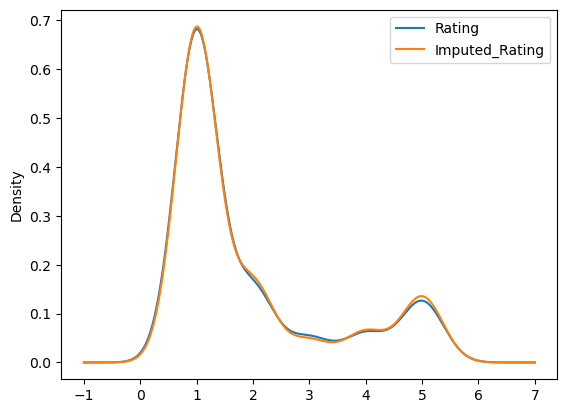

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
df['Rating'].plot(kind='kde', ax = ax)
df['Imputed_Rating'].plot(kind='kde', ax = ax)
lines, lables = ax.get_legend_handles_labels()
ax.legend(lines, lables, loc='best')

In [16]:
df.head()

,name,location,Date,Rating,Review,Image_Links,Imputed_Rating
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images'],5.0
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images'],5.0
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...,5.0
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images'],5.0
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...,5.0


In [17]:
X = df[['Review']]
y = df['Imputed_Rating']

In [18]:
X.head()

,Review
0,Amber and LaDonna at the Starbucks on Southwes...
1,** at the Starbucks by the fire station on 436...
2,I just wanted to go out of my way to recognize...
3,Me and my friend were at Starbucks and my card...
4,I’m on this kick of drinking 5 cups of warm wa...


In [19]:
y.head()

0    5.0
1    5.0
2    5.0
3    5.0
4    5.0
Name: Imputed_Rating, dtype: float64

In [20]:
print(f"X has : {X.shape}")
print(f"y has : {y.shape}")

X has : (849, 1)
y has : (849,)


In [21]:
X = X.values.flatten()

In [22]:
X

array(['Amber and LaDonna at the Starbucks on Southwest Parkway are always so warm and welcoming. There is always a smile in their voice when they greet you at the drive-thru. And their customer service is always spot-on, they always get my order right and with a smile. I would actually give them more than 5 stars if they were available.',
       '** at the Starbucks by the fire station on 436 in Altamonte Springs, FL made my day and finally helped me figure out the way to make my drink so I’d love it. She took time out to talk to me for 2 minutes to make my experience better than what I’m used to. It was much appreciated! I’ve had bad experiences one after another at the Starbucks that’s closest to me in my work building with my drinks not being great along with not great customer service from specific baristas. Niko was refreshing to speak to and pleasant. The drink was perfect! Store 11956',
       'I just wanted to go out of my way to recognize a Starbucks employee Billy at the Fra

In [23]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [24]:
corpus = []

ps = PorterStemmer()
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ', X[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(j) for j in review if not j in stopwords.words('english')]
    
    review = ' '.join(review)
    corpus.append(review)
    
    print(f"status : {i + 1}")

status : 1
status : 2
status : 3
status : 4
status : 5
status : 6
status : 7
status : 8
status : 9
status : 10
status : 11
status : 12
status : 13
status : 14
status : 15
status : 16
status : 17
status : 18
status : 19
status : 20
status : 21
status : 22
status : 23
status : 24
status : 25
status : 26
status : 27
status : 28
status : 29
status : 30
status : 31
status : 32
status : 33
status : 34
status : 35
status : 36
status : 37
status : 38
status : 39
status : 40
status : 41
status : 42
status : 43
status : 44
status : 45
status : 46
status : 47
status : 48
status : 49
status : 50
status : 51
status : 52
status : 53
status : 54
status : 55
status : 56
status : 57
status : 58
status : 59
status : 60
status : 61
status : 62
status : 63
status : 64
status : 65
status : 66
status : 67
status : 68
status : 69
status : 70
status : 71
status : 72
status : 73
status : 74
status : 75
status : 76
status : 77
status : 78
status : 79
status : 80
status : 81
status : 82
status : 83
status : 84
s

status : 641
status : 642
status : 643
status : 644
status : 645
status : 646
status : 647
status : 648
status : 649
status : 650
status : 651
status : 652
status : 653
status : 654
status : 655
status : 656
status : 657
status : 658
status : 659
status : 660
status : 661
status : 662
status : 663
status : 664
status : 665
status : 666
status : 667
status : 668
status : 669
status : 670
status : 671
status : 672
status : 673
status : 674
status : 675
status : 676
status : 677
status : 678
status : 679
status : 680
status : 681
status : 682
status : 683
status : 684
status : 685
status : 686
status : 687
status : 688
status : 689
status : 690
status : 691
status : 692
status : 693
status : 694
status : 695
status : 696
status : 697
status : 698
status : 699
status : 700
status : 701
status : 702
status : 703
status : 704
status : 705
status : 706
status : 707
status : 708
status : 709
status : 710
status : 711
status : 712
status : 713
status : 714
status : 715
status : 716
status : 717

In [26]:
corpus

['amber ladonna starbuck southwest parkway alway warm welcom alway smile voic greet drive thru custom servic alway spot alway get order right smile would actual give star avail',
 'starbuck fire station altamont spring fl made day final help figur way make drink love took time talk minut make experi better use much appreci bad experi one anoth starbuck closest work build drink great along great custom servic specif barista niko refresh speak pleasant drink perfect store',
 'want go way recogn starbuck employe billi franklin park locat run late work place order wrong locat make order smile made within second thank soo much bad morn peopl like make world better place',
 'friend starbuck card work thank worker paid drink nice seem bother paid drink made day made look like fool card work thank dillon shorelin wa safeway thank much dillon help support kind rate could',
 'kick drink cup warm water work instacart right everi locat starbuck given free hot water ask without charg realli appreci

In [38]:
voc_size = 5000
output_rating = len(df['Imputed_Rating'].unique())

In [39]:
one_hot_re = [one_hot(i, n=voc_size) for i in corpus]
one_hot_re

[[14,
  4101,
  76,
  321,
  3552,
  1821,
  3953,
  1062,
  1821,
  2013,
  2077,
  1721,
  4459,
  3383,
  3010,
  4053,
  1821,
  4552,
  1821,
  2199,
  1204,
  4079,
  2013,
  2393,
  4602,
  246,
  4493,
  931],
 [76,
  3846,
  717,
  1532,
  2546,
  3823,
  2632,
  1385,
  3906,
  4660,
  2407,
  2450,
  1595,
  2673,
  4267,
  3440,
  2698,
  2498,
  2594,
  1595,
  2972,
  184,
  2469,
  4363,
  3077,
  1329,
  2972,
  491,
  4174,
  76,
  4436,
  3898,
  784,
  2673,
  2846,
  2359,
  2846,
  3010,
  4053,
  3529,
  675,
  3156,
  4509,
  2833,
  4121,
  2673,
  3316,
  157],
 [1686,
  16,
  2450,
  4451,
  76,
  1742,
  3456,
  354,
  875,
  1747,
  4064,
  471,
  3898,
  4947,
  1204,
  126,
  1747,
  1595,
  1204,
  2013,
  2632,
  1628,
  1262,
  252,
  4570,
  4363,
  1329,
  3790,
  4527,
  4088,
  1595,
  4412,
  184,
  4947],
 [2834,
  76,
  944,
  3898,
  252,
  475,
  1189,
  2673,
  4547,
  2978,
  878,
  1189,
  2673,
  2632,
  1385,
  2632,
  2176,
  4088,
  4995

In [40]:
max_len = 0
for i in one_hot_re:
    x = len(i)
    if (x>max_len):
        max_len = x
    else:
        max_len = max_len
        
print(f"max_len : {max_len}")

max_len : 108


In [41]:
word_seq = pad_sequences(one_hot_re, padding='pre', maxlen = max_len)
word_seq

array([[   0,    0,    0, ...,  246, 4493,  931],
       [   0,    0,    0, ..., 2673, 3316,  157],
       [   0,    0,    0, ..., 4412,  184, 4947],
       ...,
       [   0,    0,    0, ...,  458, 4685, 2509],
       [   0,    0,    0, ...,    0, 1175,  195],
       [   0,    0,    0, ...,    0, 1175,  195]])

In [42]:
vector_rep = 50
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=50, input_length=max_len))
model.add(LSTM(units=100))
model.add(Dense(units=output_rating, activation='softmax'))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 108, 50)           250000    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 310905 (1.19 MB)
Trainable params: 310905 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])